# DS210 - Optimizing Portfolio to Adapt to Regime Change
## Data Retrieval
### Irene Na

## Set the environment

In [5]:
!pip install --upgrade wrds --quiet
!pip install  --upgrade openpyxl -- quiet
!pip install yfinance --quiet

import wrds
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import os 
import yfinance as yf

import openpyxl
print(openpyxl.__version__) 

ERROR: Could not find a version that satisfies the requirement quiet (from versions: none)
ERROR: No matching distribution found for quiet


c:\Users\SngeN\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


3.1.5


## Reference:
- [Historical S&P 500 Index Constituents](https://wrds-www.wharton.upenn.edu/pages/wrds-research/applications/python-replications/historical-sp-500-index-constituents/)
- https://github.com/bkelly-lab/ReplicationCrisis
- https://jkpfactors.com/

## Functions

In [3]:
def check_na_by_col(df, df_name, figsize=(8,4), rotate_x = False):
    (100*df.apply(lambda x: sum(x.isnull()))/len(df)).rename('Percentage of Missing Value by Columns').sort_values(ascending=False).to_frame()\
    .plot(title=f'{df_name} % of Missing Value by Columns', figsize=figsize)
    if rotate_x:
        plt.xticks(rotation=45)
    plt.show()

def prelim_check_data(data_tc, file_name, checkpoint_name=None):
    if checkpoint_name:
        with open(f'./{checkpoint_name}/{file_name}.pkl','rb') as f:
            data_tc = pickle.load(f)

    print('\nData shape:')
    display(data_tc.shape)

    print('Date range and frequency:')
    if 'date' in data_tc.columns:
        date_col = 'date'
        display(data_tc['date'].unique()[:5])
        display(data_tc['date'].unique()[-5:])
    elif 'eom' in data_tc.columns:
        date_col = 'eom'
        display(data_tc['eom'].unique()[:5])
        display(data_tc['eom'].unique()[-5:])

    # Char columns:
    print('Data columns:')
    display(data_tc.columns)

    # Check on missing value
    print ('Missing value check:')
    check_na_by_col(data_tc, file_name, figsize=(8,3), rotate_x=True)

    # Average stock per day:
    print ('Average stock per day is:')
    if 'permno' in data_tc.columns:
        stock_id_col = 'permno'
    else:
        stock_id_col = 'gvkey'
    display(data_tc.groupby(date_col)[stock_id_col].count().mean())

    # Stock per day chart over time
    data_tc.groupby(date_col)[stock_id_col].count().rename('Stock_count_per_day')\
        .plot(title=f'Stock Count Per Day in {file_name} Data', figsize=(8,4))
    plt.show()

    # Head of the data
    print ('The head of the data is:')
    display(data_tc.head())

def mmd_cal(df):
    df['cum_rtn']=(1+df['return']).cumprod()
    df['drawdown'] = (df['cum_rtn']-df['cum_rtn'].cummax())/df['cum_rtn'].cummax()
    df['max_drawdown'] =  df['drawdown'].cummin()
    return df

def block_distribution_plot(df, cols_to_plot, variable_names, n_per_row):
    # Distribution check
    # cols_to_plot = numerical_columns
    n = len(cols_to_plot)
    # n_per_row = 4

    fig1, ax1 = plt.subplots(n//n_per_row, n_per_row, figsize=(15,7))

    for i, col in enumerate(cols_to_plot):
        ax1[i//n_per_row, i%n_per_row].hist(df[col], color='skyblue', bins=30)
        ax1[i//n_per_row, i%n_per_row].set_title(col)
        ax1[i//n_per_row, i%n_per_row].set_ylabel('count')
        ax1[i//n_per_row, i%n_per_row].set_xlabel('value_range')

    plt.suptitle(f'Distribution Plots for {variable_names}')
    plt.subplots_adjust(top=0.90, bottom=0.01, hspace=0.8)
    plt.show()

def block_time_series_plot(df, cols_to_plot, variable_names, n_per_row):
    # Time series plots
    # cols_to_plot = numerical_columns
    n = len(cols_to_plot)
    # n_per_row = 4

    fig1, ax1 = plt.subplots(n//n_per_row, n_per_row, figsize=(15,7))

    for i, col in enumerate(cols_to_plot):
        t_series = df.groupby('date')[col].mean()
        ax1[i//n_per_row, i%n_per_row].plot(t_series)
        ax1[i//n_per_row, i%n_per_row].set_title(col)
        ax1[i//n_per_row, i%n_per_row].set_ylabel('Average value')
        ax1[i//n_per_row, i%n_per_row].set_xlabel('Time')

    plt.suptitle(f'Time Series Plots for {variable_names} (Average Per Day)')
    plt.subplots_adjust(top=0.90, bottom=0.01, hspace=0.8, wspace=0.3)
    plt.show()

## Classes

In [1]:
class Data_NN:
    '''this is the class to prepare and retreive NN (DL) used data
    the class will check the existence of checkpoint data first, 
    if not exist, then retrieve new version of data'''

    '''note: if you will create the data with new checkpoint name, you will
    need to put in WRDS user name, password, and "Y"'''

    def __init__(self, start_date='2000-01-01', train_end_date='2020-12-31'):
        self.checkpoint_name = ''
        self.data_dic = {}
        self.start_date=start_date
        self.train_end_date = train_end_date
         
    def __repr__(self):
        return f'The checkpoint name of this data is {self.checkpoint_name}, \nand data_dic keys are {list(self.data_dic.keys())}'
    
    def set_directory(self, data_directory_path):
        #IN: note this directory_path should be where the data is at
        self.dir = data_directory_path
        os.chdir(data_directory_path)

    def check_checkpoint(self, checkpoint_name):
        if checkpoint_name in os.listdir():
            self.checkpoint_name = checkpoint_name
            return True
        else:
            return False 
        
    def retrieve_data(self, checkpoint_name):
        if self.check_checkpoint(checkpoint_name):
            with open(f'./{checkpoint_name}/data_useful_info_dic.pkl','rb') as f:
                data_useful_info_dic = pickle.load(f)
            with open(f'./{checkpoint_name}/sp500_used.pkl','rb') as f:
                sp500_used = pickle.load(f)
            # Data at mkt level
            with open(f'./{checkpoint_name}/mkt_daily.pkl','rb') as f:
                mkt_daily = pickle.load(f)

            # train/test split data
            with open(f'./{checkpoint_name}/train_sp500.pkl','rb') as f:
                train_sp500 = pickle.load(f)

            with open(f'./{checkpoint_name}/test_sp500.pkl','rb') as f:
                test_sp500 = pickle.load(f)

            with open(f'./{checkpoint_name}/train_mkt.pkl','rb') as f:
                train_mkt = pickle.load(f)
            
            with open(f'./{checkpoint_name}/test_mkt.pkl','rb') as f:
                test_mkt = pickle.load(f)
            
            self.data_dic= {'data_useful_info_dic': data_useful_info_dic,
                    'sp500_used': sp500_used,
                    'mkt_daily':mkt_daily,
                    'train_sp500': train_sp500,
                    'test_sp500': test_sp500,
                    'train_mkt': train_mkt,
                    'test_mkt': test_mkt}
        
        else:
            self.prepare_data(self.start_date, checkpoint_name)
            with open(f'./{checkpoint_name}/train_sp500.pkl','rb') as f:
                train_sp500 = pickle.load(f)

            with open(f'./{checkpoint_name}/test_sp500.pkl','rb') as f:
                test_sp500 = pickle.load(f)

            with open(f'./{checkpoint_name}/train_mkt.pkl','rb') as f:
                train_mkt = pickle.load(f)
            
            with open(f'./{checkpoint_name}/test_mkt.pkl','rb') as f:
                test_mkt = pickle.load(f)
            
            self.data_dic= {'data_useful_info_dic': data_useful_info_dic,
                    'sp500_used': sp500_used,
                    'mkt_daily':mkt_daily,
                    'train_sp500': train_sp500,
                    'test_sp500': test_sp500,
                    'train_mkt': train_mkt,
                    'test_mkt': test_mkt}


    def prepare_data(self, start_date, checkpoint_name):
        '''establish connection'''
        wrds_db = wrds.Connection()

        '''Downloading the JKP data (Firm Characteristic Data) from WRDS'''
        print ('Downloading the JKP data (Firm Characteristic Data) from WRDS...')
        #IN: second version where the first five factors are based on paper
        char_chosen =['market_equity','be_me','at_gr1','ope_be','ret_12_1', # FF-5-factor
                    'ret_6_1','ret_3_1', # other mmt
                    'ret_60_12', 'ret_1_0'] # reversal

        cty_chosen = ['USA']

        sql_query= f"""
                SELECT id, eom, excntry, gvkey, permno, size_grp, me, ret_exc_lead1m, {','.join(map(str, char_chosen))}
                        FROM contrib.global_factor
                        WHERE common=1 and exch_main=1 and primary_sec=1 and obs_main=1 and
                        excntry in ({','.join("'"+str(x)+"'" for x in cty_chosen)}) and eom>=CAST('{start_date}' AS DATE)
                """
        char_data = wrds_db.raw_sql(sql_query)

        '''Download S&P500 constituents From CRSP and Compustat'''
        print ('Download S&P500 constituents From CRSP and Compustat..')
        '''Get S&P constituents in-index date range and respective return'''
        print ('Get S&P constituents in-index date range and respective return..')

        start_date_sp = start_date
        # IN: crsp.msp500list is monthly data, crsp.dsp500list is daily data; similarly crsp.msp is monthly data; crsp.dsp is daily data

        sp500_daily = wrds_db.raw_sql(f"""
                                select a.*, b.date, b.ret, b.vol
                                from crsp.dsp500list as a,
                                crsp.dsf as b
                                where a.permno=b.permno
                                and b.date >= a.start and b.date<= a.ending
                                and b.date>=CAST('{start_date_sp}' AS DATE)
                                order by date;
                                """, date_cols=['start', 'ending', 'date'])
        
        '''Get Identifier and Descriptive Data From CRSP and Compustat for merges'''
        print ('Get Identifier and Descriptive Data From CRSP and Compustat for merges..')
        # Add Other Descriptive Variables from CRSP

        mse = wrds_db.raw_sql("""
                                select comnam, ncusip, namedt, nameendt, 
                                permno, shrcd, exchcd, hsiccd, ticker
                                from crsp.msenames
                                """, date_cols=['namedt', 'nameendt'])

        # if nameendt is missing then set to today date
        mse['nameendt']=mse['nameendt'].fillna(pd.to_datetime('today'))

        # Merge with SP500 universe data
        sp500_crsp = pd.merge(sp500_daily, mse, how = 'left', on = 'permno')

        # Impose the date range restrictions
        sp500_crsp = sp500_crsp.loc[(sp500_crsp.date>=sp500_crsp.namedt) \
                                    & (sp500_crsp.date<=sp500_crsp.nameendt)]
        
        # Linking with Compustat through CCM
        ccm=wrds_db.raw_sql("""
                        select gvkey, liid as iid, lpermno as permno, linktype, linkprim, 
                        linkdt, linkenddt
                        from crsp.ccmxpf_linktable
                        where substr(linktype,1,1)='L'
                        and (linkprim ='C' or linkprim='P')
                        """, date_cols=['linkdt', 'linkenddt'])

        # if linkenddt is missing then set to today date
        ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

        # Merge the CCM data with S&P500 data
        # First just link by matching PERMNO
        sp500_crsp_ccm = pd.merge(sp500_crsp, ccm, how='left', on=['permno'])

        # Then set link date bounds
        sp500_crsp_ccm = sp500_crsp_ccm.loc[(sp500_crsp_ccm['date']>=sp500_crsp_ccm['linkdt'])\
                                &(sp500_crsp_ccm['date']<=sp500_crsp_ccm['linkenddt'])]

        '''Merge S&P500 Universe CRSP, Compustat Data with Firm Characteristic data'''
        print ('Merge S&P500 Universe CRSP, Compustat Data with Firm Characteristic data..')

        '''Prepare char_data to be merged'''
        print ('preparing char_data to be merged')
        # IN - get the index we need for char_data from sp500
        sp500_crsp_ccm_adj = sp500_crsp_ccm.copy().drop_duplicates(subset=['date','permno'])
        sp500_crsp_ccm_adj = sp500_crsp_ccm_adj.set_index(['date','permno'])
        daily_index = pd.date_range(start=sp500_crsp_ccm_adj.index.get_level_values('date').min(),
                                    end=sp500_crsp_ccm_adj.index.get_level_values('date').max(),
                                    freq='D')
        
        # IN: Use sp500_crsp_ccm_adj's extended index with daily frequency (note not BD) to reindex char_data
        char_data_adj = char_data.copy()[['permno','eom']+char_chosen+['ret_exc_lead1m']].dropna(subset=['permno'])
        char_data_adj['date'] = pd.to_datetime(char_data_adj['eom'])

        char_data_adj = char_data_adj.set_index(['date','permno'])\
            .reindex(pd.MultiIndex.from_product([daily_index, sp500_crsp_ccm_adj.index.get_level_values('permno').unique()],
                                                                    names=['date','permno']))\
                                                                    .groupby('permno').ffill().reset_index()
        
        '''Merge sp500 data with reindexed firm characteristic data'''
        print ('Merge sp500 data with prepared firm characteristic data...')    
        sp500_comb = pd.merge(sp500_crsp_ccm, char_data_adj, on=['date','permno'], how='left').sort_values(by=['permno','date']).reset_index()

        '''prepare data to be used for analysis'''
        print ('Prepare data to be used for later analysis..')

        #IN: important columns information:
        useful_columns = ['permno','date','comnam','ncusip','ticker','gvkey','hsiccd','ret','vol','ret_exc_lead1m']+char_chosen
        name_map = {'comnam':'company_name',
                    'hsiccd':'industry_code',
                    'ret':'return',
                    'vol':'volume',
                    'ret_exc_lead1m':'return_lead1m',
                    'be_me':'book_to_equity',
                    'at_gr1':'asset_growth',
                    'ope_be':'opt_to_book_eq'}

        time_columns = ['date']
        identifier_columns = [name_map[x] if x in name_map else x for x in ['permno','ncusip','ticker','gvkey']]
        categorical_columns = [name_map[x] if x in name_map else x for x in ['comnam','hsiccd']]
        numerical_columns = [name_map[x] if x in name_map else x for x in char_chosen + ['ret','vol','ret_exc_lead1m']]

        sp500_used = sp500_comb[useful_columns].rename(columns=name_map).drop_duplicates(subset=['permno','date'])

        '''initial check of data'''
        prelim_check_data(sp500_used, 'sp500_used', checkpoint_name=None)

        '''add selective daily metrics'''
        print ('Add selective daily metrics..')
        ## calculating the daily metrics
        ret_12m_d = sp500_used.set_index(['permno','date'])['return']\
            .groupby('permno').apply(lambda x: (x.rolling(21*12).sum()).droplevel(0)).rename('ret_12m_d').reset_index()

        ret_6m_d = sp500_used.set_index(['permno','date'])['return']\
            .groupby('permno').apply(lambda x: (x.rolling(21*6).sum()).droplevel(0)).rename('ret_6m_d').reset_index()

        ret_3m_d = sp500_used.set_index(['permno','date'])['return']\
            .groupby('permno').apply(lambda x: (x.rolling(21*3).sum()).droplevel(0)).rename('ret_3m_d').reset_index()

        ret_1m_d = sp500_used.set_index(['permno','date'])['return']\
            .groupby('permno').apply(lambda x: (x.rolling(21).sum()).droplevel(0)).rename('ret_1m_d').reset_index()

        ## adding them to sp500 data set
        print(f'sp500_used shape before adding daily metrics: {sp500_used.shape}')
        for data_d in [ret_12m_d, ret_6m_d, ret_3m_d, ret_1m_d]:
            sp500_used = pd.merge(sp500_used, data_d, on=['permno','date'], how='left')
        print(f'sp500_used shape after adding daily metrics: {sp500_used.shape}')

        ## update numerical columns to include the new daily metrics
        numerical_columns = numerical_columns + ['ret_12m_d','ret_6m_d','ret_3m_d','ret_1m_d']

        '''Further data cleaning'''
        print ('Further data cleaning..')
        print ('Clean outliers based on preliminary checks (on operating profit on book equity)..')

        print(f'sp500_used shape before outlier cleanng: {sp500_used.shape}')
        
        abnormal_threshold = 30 
        sp500_used.loc[sp500_used['opt_to_book_eq']>abnormal_threshold, 'opt_to_book_eq'] = np.nan
        temp_ffill = sp500_used.set_index(['permno','date'])['opt_to_book_eq'].groupby('permno').ffill().reset_index()
        sp500_used = pd.merge(sp500_used.drop(columns=['opt_to_book_eq']), temp_ffill, on=['permno','date'], how='left')

        print(f'sp500_used shape after outlier cleanng: {sp500_used.shape}')

        # Packing important inputs for later analysis for saving
        data_useful_info_dic={}

        data_useful_info_dic['useful_columns_raw'] = useful_columns
        data_useful_info_dic['name_map'] = name_map
        data_useful_info_dic['time_columns'] = time_columns
        data_useful_info_dic['identifier_columns'] = identifier_columns
        data_useful_info_dic['categorical_columns'] = categorical_columns
        data_useful_info_dic['numerical_columns'] = numerical_columns

        # plot checking resulting data
        print ('S&P data plot after processing..')
        block_distribution_plot(sp500_used, numerical_columns, 'Numerical Variables', n_per_row=4)
        block_time_series_plot(sp500_used, numerical_columns, 'Numerical Variables', n_per_row=4)

        # split train and test data
        print ('Split train and test data - S&P500..')
        train_sp500 = sp500_used[sp500_used['date']<=self.train_end_date]
        test_sp500 = sp500_used[sp500_used['date']>self.train_end_date]

        '''Retrieve market level info'''
        print ('Retrieve market level data..')
        print ('Retrieve S&P data..')
        # Download S&P 500 historical data
        sp500_mkt = yf.download('^GSPC', start='1990-01-01', end='2024-12-31')
        sp500_mkt = sp500_mkt.droplevel(1, axis=1)
        sp500_mkt.index = pd.to_datetime(sp500_mkt.index) #IN: to make sure it's datetime index

        # Calculate daily returns
        sp500_mkt['return'] = sp500_mkt['Close'].pct_change()
        sp500_mkt = mmd_cal(sp500_mkt)

        print('Retrieve Treasury data..')
        # Treasury data
        start_date_tsy = '2000-01-01'
        end_time_tsy = '2023-01-01'

        tickers = {
            "tsy10yr": "^TNX",
            "tsy5yr": "^FVX",
            "tsy2yr": "^IRX"  # Note: ^IRX is for 13-week T-bills, but you can replace it with the appropriate 2-year ticker if available
        }

        # Fetch historical yield data
        data = {}
        for bond, ticker in tickers.items():
            data[bond] = yf.download(ticker, start=start_date_tsy, end=end_time_tsy).droplevel(1, axis=1)["Close"]

        # Combine data into a single DataFrame
        yield_data = pd.DataFrame(data)
        yield_data.index = pd.to_datetime(yield_data.index) 

        print('Combine market level data')
        mkt_daily = pd.concat([sp500_mkt\
                       .rename(columns=dict(zip(sp500_mkt.columns,
                                        [f'{x}_sp' for x in sp500_mkt.columns]))), 
                                        yield_data/100], axis=1).loc[start_date_tsy:end_time_tsy,:]
        print ('Mkt data plot..')
        mkt_daily[['return_sp','tsy10yr','tsy2yr','tsy5yr']].plot(title='Market Data Plot')
        plt.show()

        # split market level data into train and test
        print ('Split train and test data - Market data..')
        train_mkt = mkt_daily.loc[:self.train_end_date,:]
        test_mkt = mkt_daily.loc[self.train_end_date:,:]

        '''save data'''
        # Save this data locally for later use
        print ('Saving data..')
        os.mkdir(checkpoint_name)
        with open(f'./{checkpoint_name}/char_data.pkl','wb') as f:
            pickle.dump(char_data, f)
        
        with open(f'./{checkpoint_name}/sp500_crsp.pkl','wb') as f:
            pickle.dump(sp500_crsp, f)

        with open(f'./{checkpoint_name}/sp500_crsp_ccm.pkl','wb') as f:
            pickle.dump(sp500_crsp_ccm, f)

        with open(f'./{checkpoint_name}/sp500_comb.pkl','wb') as f:
            pickle.dump(sp500_comb, f)

        with open(f'./{checkpoint_name}/sp500_used.pkl','wb') as f:
            pickle.dump(sp500_used, f)
        
        with open(f'./{checkpoint_name}/data_useful_info_dic.pkl','wb') as f:
            pickle.dump(data_useful_info_dic, f)

        with open(f'./{checkpoint_name}/mkt_daily.pkl','wb') as f:
            pickle.dump(mkt_daily, f)

        with open(f'./data-used/{checkpoint_name}/train_sp500.pkl','wb') as f:
            pickle.dump(train_sp500, f)

        with open(f'./data-used/{checkpoint_name}/test_sp500.pkl','wb') as f:
            pickle.dump(test_sp500, f)

        with open(f'./data-used/{checkpoint_name}/train_mkt.pkl','wb') as f:
            pickle.dump(train_mkt, f)

        with open(f'./data-used/{checkpoint_name}/test_mkt.pkl','wb') as f:
            pickle.dump(test_mkt, f)

### Execution Main

In [2]:
def data_main(data_directory, data_checkpoint_name, start_date, train_end_date, verbose=True):
    # data_directory = r'C:\Mine\U.S.-2019\NPB living - 2 - related\School-part time\Berkeley-202308\MIDS classes\210-Capstone\Project-related\code-IN/data-used'
    # data_checkpoint_name = 'data_checkpoint1'
    # start_date = '2000-01-01'

    data_obj = Data_NN(start_date, train_end_date)
    print(data_obj)

    data_obj.set_directory(data_directory)
    data_obj.retrieve_data(data_checkpoint_name)

    data_dic_used = data_obj.data_dic
    print(data_obj)

    # check key data
    if verbose:
        print('Check the key dataset:')
        prelim_check_data(data_dic_used['sp500_used'], 'sp500_used')

    return data_obj


### Examples:

The checkpoint name of this data is , 
and data_dic keys are []
The checkpoint name of this data is data_checkpoint1, 
and data_dic keys are ['data_useful_info_dic', 'sp500_used', 'mkt_daily', 'train_sp500', 'test_sp500', 'train_mkt', 'test_mkt']
Check the key dataset:

Data shape:


(3018361, 23)

Date range and frequency:


<DatetimeArray>
['2000-01-03 00:00:00', '2000-01-04 00:00:00', '2000-01-05 00:00:00',
 '2000-01-06 00:00:00', '2000-01-07 00:00:00']
Length: 5, dtype: datetime64[ns]

<DatetimeArray>
['2023-12-22 00:00:00', '2023-12-26 00:00:00', '2023-12-27 00:00:00',
 '2023-12-28 00:00:00', '2023-12-29 00:00:00']
Length: 5, dtype: datetime64[ns]

Data columns:


Index(['permno', 'date', 'company_name', 'ncusip', 'ticker', 'gvkey',
       'industry_code', 'return', 'volume', 'return_lead1m', 'market_equity',
       'book_to_equity', 'asset_growth', 'ret_12_1', 'ret_6_1', 'ret_3_1',
       'ret_60_12', 'ret_1_0', 'ret_12m_d', 'ret_6m_d', 'ret_3m_d', 'ret_1m_d',
       'opt_to_book_eq'],
      dtype='object')

Missing value check:


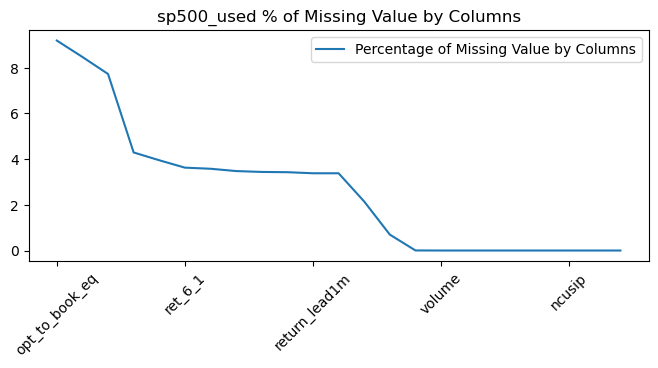

Average stock per day is:


499.976975318867

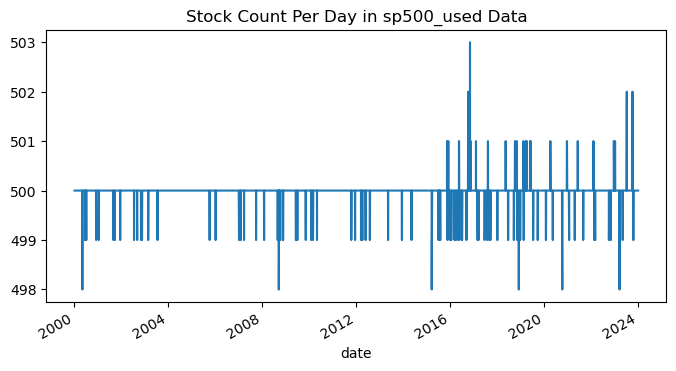

The head of the data is:


,permno,date,company_name,ncusip,ticker,gvkey,industry_code,return,volume,return_lead1m,...,ret_12_1,ret_6_1,ret_3_1,ret_60_12,ret_1_0,ret_12m_d,ret_6m_d,ret_3m_d,ret_1m_d,opt_to_book_eq
0,10078,2000-01-03,SUN MICROSYSTEMS INC,86681010,SUNW,012136,3571,-0.012107,15270527.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10078,2000-01-04,SUN MICROSYSTEMS INC,86681010,SUNW,012136,3571,-0.062092,21098710.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10078,2000-01-05,SUN MICROSYSTEMS INC,86681010,SUNW,012136,3571,0.001742,30073258.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10078,2000-01-06,SUN MICROSYSTEMS INC,86681010,SUNW,012136,3571,-0.053913,22741999.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10078,2000-01-07,SUN MICROSYSTEMS INC,86681010,SUNW,012136,3571,0.056985,20450260.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Retrieve data 
# Example one: data is already created and saved, we only retrieve it:
data_directory = r'C:\Mine\U.S.-2019\NPB living - 2 - related\School-part time\Berkeley-202308\MIDS classes\210-Capstone\Project-related\code-IN/data-used'
data_checkpoint_name = 'data_checkpoint1'
start_date = '2000-01-01'
train_end_date = '2020-12-31'

data_test_obj1 = data_main(data_directory, data_checkpoint_name, start_date, train_end_date)

The checkpoint name of this data is , 
and data_dic keys are []
WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
Download S&P500 constituents From CRSP and Compustat..
Get S&P constituents in-index date range and respective return..
Get Identifier and Descriptive Data From CRSP and Compustat for merges..
Merge S&P500 Universe CRSP, Compustat Data with Firm Characteristic data..
preparing char_data to be merged
Merge sp500 data with prepared firm characteristic data...
Prepare data to be used for later analysis..

Data shape:


(3018361, 19)

Date range and frequency:


<DatetimeArray>
['2000-01-03 00:00:00', '2000-01-04 00:00:00', '2000-01-05 00:00:00',
 '2000-01-06 00:00:00', '2000-01-07 00:00:00']
Length: 5, dtype: datetime64[ns]

<DatetimeArray>
['2023-12-22 00:00:00', '2023-12-26 00:00:00', '2023-12-27 00:00:00',
 '2023-12-28 00:00:00', '2023-12-29 00:00:00']
Length: 5, dtype: datetime64[ns]

Data columns:


Index(['permno', 'date', 'company_name', 'ncusip', 'ticker', 'gvkey',
       'industry_code', 'return', 'volume', 'return_lead1m', 'market_equity',
       'book_to_equity', 'asset_growth', 'opt_to_book_eq', 'ret_12_1',
       'ret_6_1', 'ret_3_1', 'ret_60_12', 'ret_1_0'],
      dtype='object')

Missing value check:


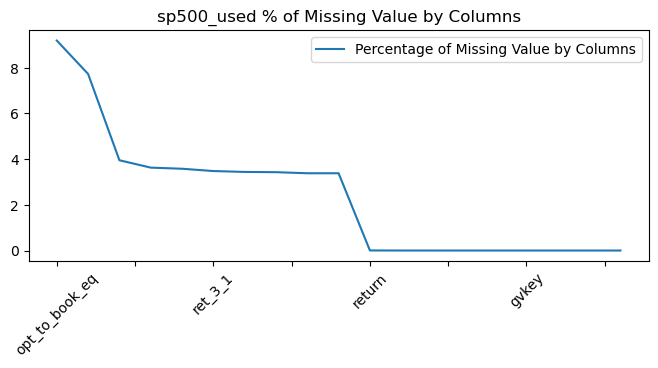

Average stock per day is:


499.976975318867

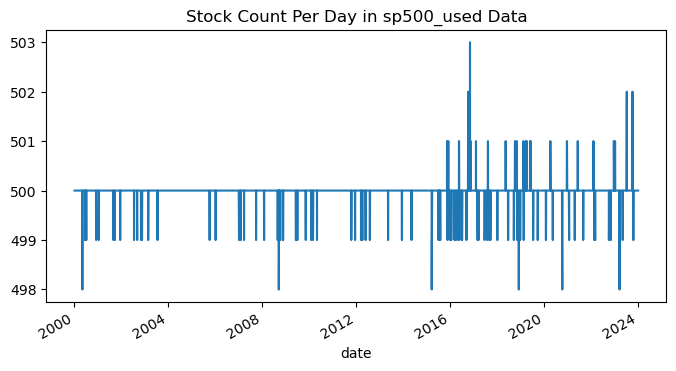

The head of the data is:


,permno,date,company_name,ncusip,ticker,gvkey,industry_code,return,volume,return_lead1m,market_equity,book_to_equity,asset_growth,opt_to_book_eq,ret_12_1,ret_6_1,ret_3_1,ret_60_12,ret_1_0
0,10078,2000-01-03,SUN MICROSYSTEMS INC,86681010,SUNW,012136,3571,-0.012107,15270527.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10078,2000-01-04,SUN MICROSYSTEMS INC,86681010,SUNW,012136,3571,-0.062092,21098710.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10078,2000-01-05,SUN MICROSYSTEMS INC,86681010,SUNW,012136,3571,0.001742,30073258.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10078,2000-01-06,SUN MICROSYSTEMS INC,86681010,SUNW,012136,3571,-0.053913,22741999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10078,2000-01-07,SUN MICROSYSTEMS INC,86681010,SUNW,012136,3571,0.056985,20450260.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Add selective daily metrics..
sp500_used shape before adding daily metrics: (3018361, 19)
sp500_used shape after adding daily metrics: (3018361, 23)
Further data cleaning..
Clean outliers based on preliminary checks (on operating profit on book equity)..
sp500_used shape before outlier cleanng: (3018361, 23)
sp500_used shape after outlier cleanng: (3018361, 23)
S&P data plot after processing..


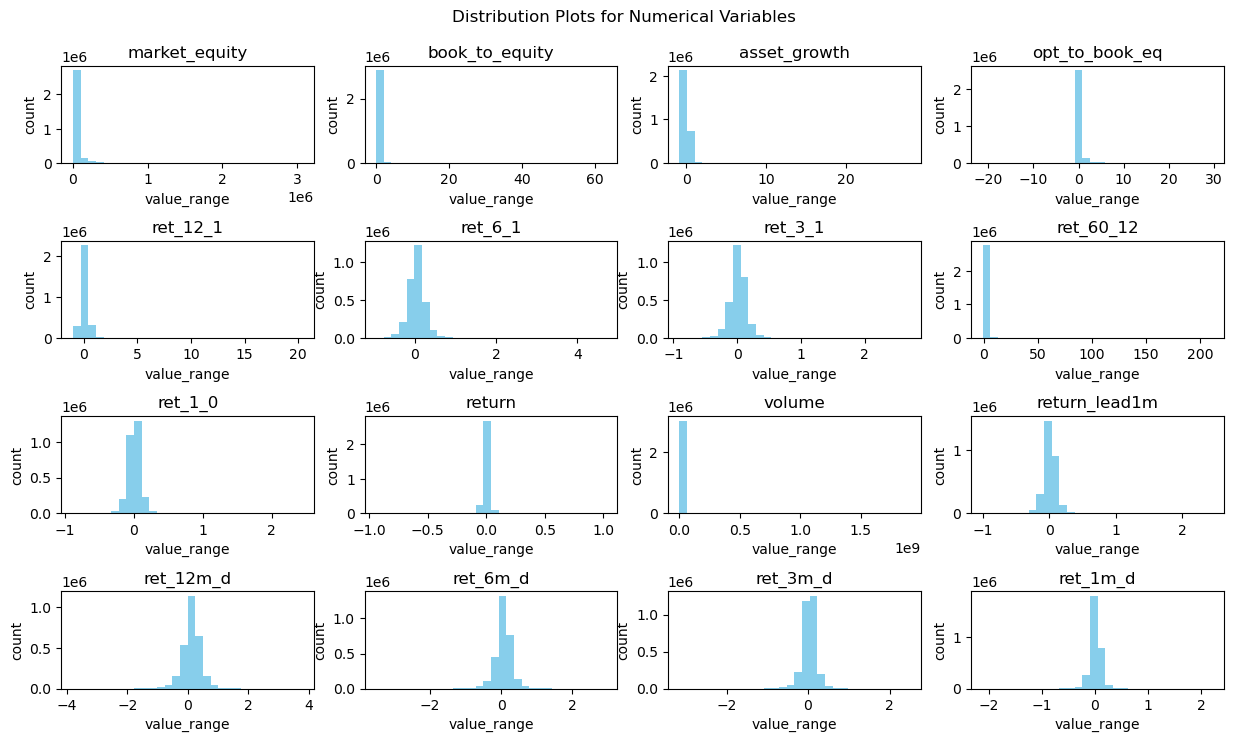

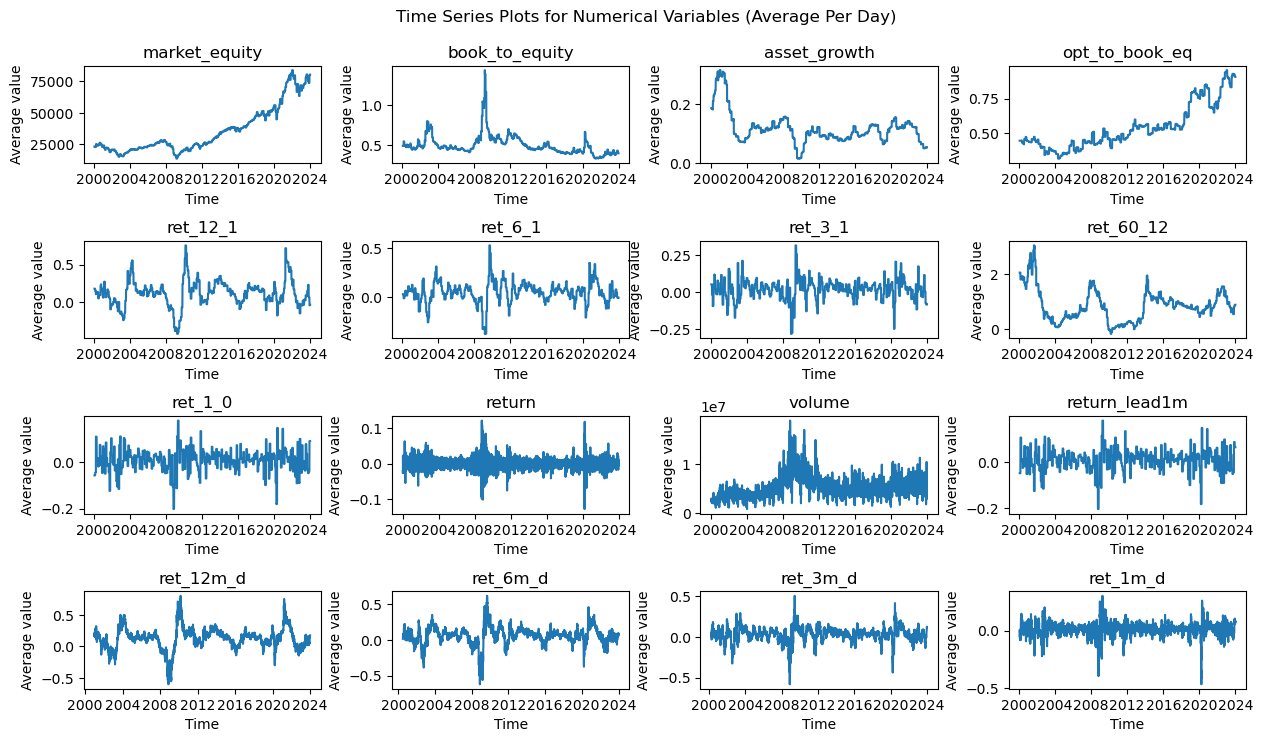

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Retrieve market level data..
Retrieve S&P data..
Retrieve Treasury data..


Combine market level data
Mkt data plot..


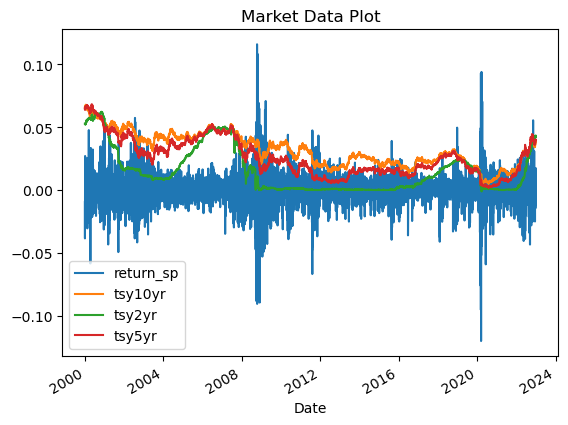

Saving data..
The checkpoint name of this data is , 
and data_dic keys are ['data_useful_info_dic', 'sp500_used', 'mkt_daily']
Check the key dataset:

Data shape:


(3018361, 23)

Date range and frequency:


<DatetimeArray>
['2000-01-03 00:00:00', '2000-01-04 00:00:00', '2000-01-05 00:00:00',
 '2000-01-06 00:00:00', '2000-01-07 00:00:00']
Length: 5, dtype: datetime64[ns]

<DatetimeArray>
['2023-12-22 00:00:00', '2023-12-26 00:00:00', '2023-12-27 00:00:00',
 '2023-12-28 00:00:00', '2023-12-29 00:00:00']
Length: 5, dtype: datetime64[ns]

Data columns:


Index(['permno', 'date', 'company_name', 'ncusip', 'ticker', 'gvkey',
       'industry_code', 'return', 'volume', 'return_lead1m', 'market_equity',
       'book_to_equity', 'asset_growth', 'ret_12_1', 'ret_6_1', 'ret_3_1',
       'ret_60_12', 'ret_1_0', 'ret_12m_d', 'ret_6m_d', 'ret_3m_d', 'ret_1m_d',
       'opt_to_book_eq'],
      dtype='object')

Missing value check:


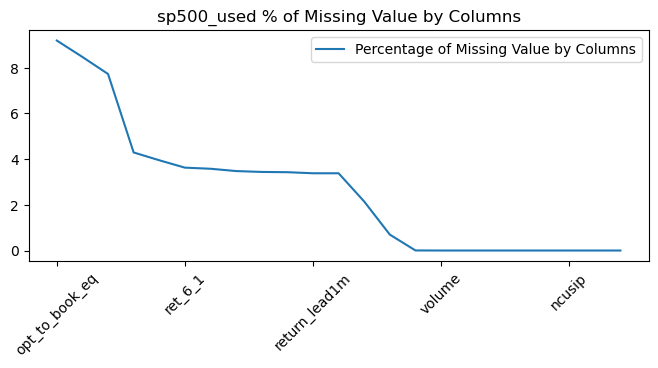

Average stock per day is:


499.976975318867

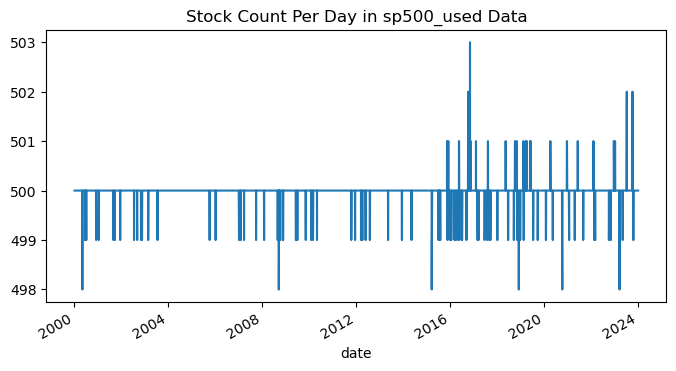

The head of the data is:


,permno,date,company_name,ncusip,ticker,gvkey,industry_code,return,volume,return_lead1m,...,ret_12_1,ret_6_1,ret_3_1,ret_60_12,ret_1_0,ret_12m_d,ret_6m_d,ret_3m_d,ret_1m_d,opt_to_book_eq
0,10078,2000-01-03,SUN MICROSYSTEMS INC,86681010,SUNW,012136,3571,-0.012107,15270527.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10078,2000-01-04,SUN MICROSYSTEMS INC,86681010,SUNW,012136,3571,-0.062092,21098710.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10078,2000-01-05,SUN MICROSYSTEMS INC,86681010,SUNW,012136,3571,0.001742,30073258.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10078,2000-01-06,SUN MICROSYSTEMS INC,86681010,SUNW,012136,3571,-0.053913,22741999.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10078,2000-01-07,SUN MICROSYSTEMS INC,86681010,SUNW,012136,3571,0.056985,20450260.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Example two: checkpoint doesn't exist, create data before retrieving
data_directory = r'C:\Mine\U.S.-2019\NPB living - 2 - related\School-part time\Berkeley-202308\MIDS classes\210-Capstone\Project-related\code-IN/data-used'
data_checkpoint_name2 = 'data_checkpoint2'
start_date = '2000-01-01'
train_end_date = '2020-12-31'

data_test_obj2 = data_main(data_directory, data_checkpoint_name2, start_date, train_end_date)

# data_test2 = Data_NN(start_date)
# print(data_test2)

# data_test2.set_directory(data_directory)
# data_test2.retrieve_data(data_checkpoint_name2)
# data_dic_used2 = data_test2.data_dic
# print(data_test2)

# # check key data
# print('\nCheck the key dataset:')
# prelim_check_data(data_dic_used2['sp500_used'], 'sp500_used')